# Régression polynômiale et pileline

Le notebook compare plusieurs de modèles de régression polynômiale.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
data = load_wines_dataset()
X = data.drop(['quality', 'color'], axis=1)
y = data['quality']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données. Pour ce cas particulier, c'est d'autant plus important que les polynômes prendront de très grandes valeurs si cela n'est pas fait et les librairies de calculs n'aiment pas les ordres de grandeurs trop différents.

In [4]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

La transformation [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) créée de nouvelles features en multipliant les variables les unes avec les autres. Pour le degré deux et trois features $a, b, c$, on obtient les nouvelles features : $1, a, b, c, a^2, ab, ac, b^2, bc, c^2$.

In [5]:
from time import clock
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

r2ts = []
r2es = []
degs = []
tts = []
models = []

for d in range(1, 5):
    begin = clock()
    pipe = make_pipeline(PolynomialFeatures(degree=d), 
                         LinearRegression())
    pipe.fit(X_train_norm, y_train)
    duree = clock() - begin
    r2t = r2_score(y_train, pipe.predict(X_train_norm))
    r2e = r2_score(y_test, pipe.predict(X_test_norm))
    degs.append(d)
    r2ts.append(r2t)
    r2es.append(r2e)
    tts.append(duree)
    models.append(pipe)
    print(d, r2t, r2e, duree)

1 0.18338556545227058 0.19158045143152547 0.007406230999977482
2 0.31702449501751706 0.2853390064172002 0.028239440876374373
3 0.4034114978449721 0.002673355995538418 0.16001836249089874
4 0.592417816824836 -1422.0048454945925 1.319577267647132


In [6]:
import pandas
df = pandas.DataFrame(dict(temps=tts, r2_train=r2ts, r2_test=r2es, degré=degs))
df.set_index('degré')

,r2_test,r2_train,temps
degré,,,
1,0.191580,0.183386,0.007406
2,0.285339,0.317024,0.028239
3,0.002673,0.403411,0.160018
4,-1422.004845,0.592418,1.319577


Le polynômes de degré 2 paraît le meilleur modèle. Le temps de calcul est multiplié par 10 à chaque fois, ce qui correspond au nombre de features. On voit néanmoins que l'ajout de features croisée fonctionne sur ce jeu de données. Mais au delà de 3, la régression produit des résultats très mauvais sur la base de test alors qu'ils continuent d'augmenter sur la base d'apprentissage. Voyons cela un peu plus en détail.

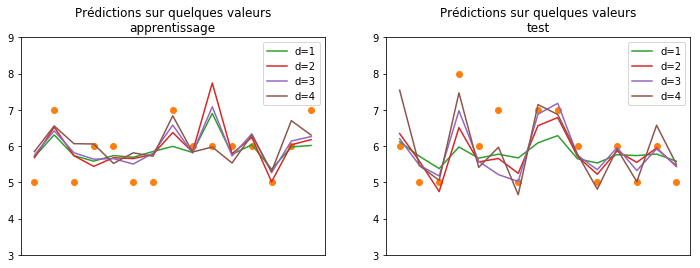

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

n = 15
ax[0].plot(y_train[:n].reset_index(), 'o')
ax[1].plot(y_test[:n].reset_index(), 'o')
ax[0].set_title('Prédictions sur quelques valeurs\napprentissage')
ax[1].set_title('Prédictions sur quelques valeurs\ntest')
for x in ax:
    x.set_ylim([3, 9])
    x.get_xaxis().set_visible(False)

for model in models:
    d = model.get_params()['polynomialfeatures__degree']
    tr = model.predict(X_train_norm[:n])
    te = model.predict(X_test_norm[:n])
    ax[0].plot(tr, label="d=%d" % d)
    ax[1].plot(te, label="d=%d" % d)
ax[0].legend()
ax[1].legend();

Le modèle de degré 4 a l'air performant sur la base d'apprentissage mais s'égare complètement sur la base de test comme s'il était surpris des valeurs rencontrées sur la base de test. On dit que le modèle fait du [sur-apprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) ou [overfitting](https://en.wikipedia.org/wiki/Overfitting) en anglais. Le polynôme de degré fonctionne mieux que la régression linéaire simple. On peut se demander quelles sont les variables croisées qui ont un impact sur la performance. On utilise le modèle [statsmodels](http://www.statsmodels.org/stable/index.html).

In [8]:
poly = PolynomialFeatures(degree=2)
poly_feat_train = poly.fit_transform(X_train_norm)
poly_feat_test = poly.fit_transform(X_test_norm)

In [9]:
from statsmodels.regression.linear_model import OLS
model = OLS(y_train, poly_feat_train)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.306     
Dependent Variable: quality          AIC:                10827.9713
Date:               2018-02-05 23:58 BIC:                11327.7983
No. Observations:   4872             Log-Likelihood:     -5337.0   
Df Model:           76               F-statistic:        29.28     
Df Residuals:       4795             Prob (F-statistic): 0.00      
R-squared:          0.317            Scale:              0.53202   
-------------------------------------------------------------------
          Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const   -2121.0425  1930.0355 -1.0990 0.2718  -5904.7976  1662.7126
x1         34.4479    23.7782  1.4487 0.1475    -12.1684    81.0641
x2       -689.9364   159.0150 -4.3388 0.0000  -1001.6787  -378.1941
x3       -122.7946   196.3628 -0.6253 0.5318   -507.7559   262.1666
x4          3.5408    12.8721  0.2751 0.7833    -21.6945    28.7761
x5      -1025.7897   691.3919 -1.4837 0.1380  -2381.2351   329.6556
x6         32.2945     8.0475  4.0130 0.0001     16.5176    48.0713
x7         72.4087    21.8551  3.3131 0.0009     29.5628   115.2546
x8      -2448.9049   734.8628 -3.3325 0.0009  -3889.5731 -1008.2367
x9        184.5404   197.0670  0.9364 0.3491   -201.8014   570.8822
x10      -348.3414   169.7916 -2.0516 0.0403   -681.2108   -15.4720
x11       264.0042    24.1476 10.9329 0.0000    216.6637   311.3446
x12      2063.8235  1921.1220  1.0743 0.2828  -1702.4572  5830.1041
x13       274.1270   148.5901  1.8449 0.0651    -17.1777   565.4318
x14       -54.0401   199.4799 -0.2709 0.7865   -445.1123   337.0321
x15        -2.7602    21.7030 -0.1272 0.8988    -45.3080    39.7876
x16     -1054.3033   564.3497 -1.8682 0.0618  -2160.6876    52.0810
x17       -21.6219     9.5079 -2.2741 0.0230    -40.2617    -2.9821
x18       -27.7397    20.8556 -1.3301 0.1836    -68.6264    13.1469
x19      1508.2148  1120.6308  1.3459 0.1784   -688.7358  3705.1653
x20      -151.2348   276.0650 -0.5478 0.5838   -692.4488   389.9793
x21       545.3829   167.1795  3.2623 0.0011    217.6344   873.1314
x22      -112.1462    25.9730 -4.3178 0.0000   -163.0653   -61.2271
x23      2347.1982  2041.2684  1.1499 0.2503  -1654.6245  6349.0209
x24       -57.3374  1546.4961 -0.0371 0.9704  -3089.1794  2974.5046
x25      -264.3349   130.2818 -2.0289 0.0425   -519.7469    -8.9228
x26      1818.4617  4214.1797  0.4315 0.6661  -6443.2641 10080.1875
x27       163.8869    62.9234  2.6045 0.0092     40.5282   287.2457
x28       508.4900   140.6821  3.6145 0.0003    232.6886   784.2915
x29        71.6341  5090.2074  0.0141 0.9888  -9907.5081 10050.7763
x30     -1053.5719  1533.5403 -0.6870 0.4921  -4060.0146  1952.8708
x31      -250.9439  1308.3299 -0.1918 0.8479  -2815.8708  2313.9830
x32       701.6655   178.3054  3.9352 0.0001    352.1052  1051.2258
x33      1579.2091  2161.0234  0.7308 0.4650  -2657.3884  5815.8066
x34      -355.1992   163.4114 -2.1737 0.0298   -675.5604   -34.8379
x35      2330.2039  4721.5435  0.4935 0.6217  -6926.1879 11586.5956
x36        69.8747    80.9722  0.8629 0.3882    -88.8679   228.6173
x37        88.1639   173.9203  0.5069 0.6122   -252.7997   429.1276
x38     15270.5381  7854.1785  1.9443 0.0519   -127.2556 30668.3319
x39     -5874.9664  2100.1200 -2.7974 0.0052  -9992.1653 -1757.7676
x40     -1456.3819  1625.3649 -0.8960 0.3703  -4642.8429  1730.0791
x41       662.5817   236.0364  2.8071 0.0050    199.8421  1125.3212
x42      2079.2823  1929.9927  1.0774 0.2814  -1704.3889  5862.9535
x43      2413.1792   733.2758  3.2910 0.0010    975.6222  3850.7362
x44        -6.5499     4.9237 -1.3303 0.1835    -16.2027     3.1029
x45         1.4598    11.7465  0.1243 0.9011    -21.5688    24.4884
x46      1151.8890   714.

Ce n'est pas très lisible. Il faut ajouter le nom de chaque variable et recommencer.

In [10]:
names = poly.get_feature_names(input_features=data.columns[:-2])
pft = pandas.DataFrame(poly_feat_train, columns=names)
pft.head()

,1,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,...,density^2,density pH,density sulphates,density alcohol,pH^2,pH sulphates,pH alcohol,sulphates^2,sulphates alcohol,alcohol^2
0,1.0,0.034944,0.000884,0.002063,0.083360,0.000227,0.210506,0.972538,0.004215,0.012588,...,0.000018,0.000053,0.000010,0.000163,0.000158,0.000029,0.000488,0.000005,0.000088,0.001500
1,1.0,0.136160,0.004600,0.005336,0.040480,0.000994,0.349600,0.901599,0.018339,0.062560,...,0.000336,0.001147,0.000256,0.003678,0.003914,0.000875,0.012547,0.000196,0.002805,0.040224
2,1.0,0.061354,0.001534,0.002334,0.071357,0.000247,0.226742,0.966988,0.006656,0.020607,...,0.000044,0.000137,0.000014,0.000431,0.000425,0.000044,0.001333,0.000005,0.000138,0.004185
3,1.0,0.041040,0.001313,0.001696,0.071683,0.000274,0.142271,0.984954,0.005466,0.016690,...,0.000030,0.000091,0.000016,0.000272,0.000279,0.000048,0.000831,0.000008,0.000144,0.002480
4,1.0,0.034093,0.001354,0.001855,0.041112,0.000276,0.260709,0.962616,0.004993,0.015592,...,0.000025,0.000078,0.000013,0.000238,0.000243,0.000041,0.000743,0.000007,0.000124,0.002269


In [11]:
results.summary2(xname=pft.columns)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Ordinary least squares
=====================================================================================================
Model:                          OLS                         Adj. R-squared:                0.306     
Dependent Variable:             quality                     AIC:                           10827.9713
Date:                           2018-02-05 23:58            BIC:                           11327.7983
No. Observations:               4872                        Log-Likelihood:                -5337.0   
Df Model:                       76                          F-statistic:                   29.28     
Df Residuals:                   4795                        Prob (F-statistic):            0.00      
R-squared:                      0.317                       Scale:                         0.53202   
-----------------------------------------------------------------------------------------------------
                                            Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-----------------------------------------------------------------------------------------------------
1                                         -2121.0425  1930.0355 -1.0990 0.2718  -5904.7976  1662.7126
fixed_acidity                                34.4479    23.7782  1.4487 0.1475    -12.1684    81.0641
volatile_acidity                           -689.9364   159.0150 -4.3388 0.0000  -1001.6787  -378.1941
citric_acid                                -122.7946   196.3628 -0.6253 0.5318   -507.7559   262.1666
residual_sugar                                3.5408    12.8721  0.2751 0.7833    -21.6945    28.7761
chlorides                                 -1025.7897   691.3919 -1.4837 0.1380  -2381.2351   329.6556
free_sulfur_dioxide                          32.2945     8.0475  4.0130 0.0001     16.5176    48.0713
total_sulfur_dioxide                         72.4087    21.8551  3.3131 0.0009     29.5628   115.2546
density                                   -2448.9049   734.8628 -3.3325 0.0009  -3889.5731 -1008.2367
pH                                          184.5404   197.0670  0.9364 0.3491   -201.8014   570.8822
sulphates                                  -348.3414   169.7916 -2.0516 0.0403   -681.2108   -15.4720
alcohol                                     264.0042    24.1476 10.9329 0.0000    216.6637   311.3446
fixed_acidity^2                            2063.8235  1921.1220  1.0743 0.2828  -1702.4572  5830.1041
fixed_acidity volatile_acidity              274.1270   148.5901  1.8449 0.0651    -17.1777   565.4318
fixed_acidity citric_acid                   -54.0401   199.4799 -0.2709 0.7865   -445.1123   337.0321
fixed_acidity residual_sugar                 -2.7602    21.7030 -0.1272 0.8988    -45.3080    39.7876
fixed_acidity chlorides                   -1054.3033   564.3497 -1.8682 0.0618  -2160.6876    52.0810
fixed_acidity free_sulfur_dioxide           -21.6219     9.5079 -2.2741 0.0230    -40.2617    -2.9821
fixed_acidity total_sulfur_dioxide          -27.7397    20.8556 -1.3301 0.1836    -68.6264    13.1469
fixed_acidity density                      1508.2148  1120.6308  1.3459 0.1784   -688.7358  3705.1653
fixed_acidity pH                           -151.2348   276.0650 -0.5478 0.5838   -692.4488   389.9793
fixed_acidity sulphates                     545.3829   167.1795  3.2623 0.0011    217.6344   873.1314
fixed_acidity alcohol                      -112.1462    25.9730 -4.3178 0.0000   -163.0653   -61.2271
volatile_acidity^2                         2347.1982  2041.2684  1.1499 0.2503  -1654.6245  6349.0209
volatile_acidity citric_acid                -57.3374  1546.4961 -0.0371 0.9704  -3089.1794  2974.5046
volatile_acidity residual_sugar            -264.3349   130.2818 -2.0289 0.0425   -519.7469    -8.9228
volatile_acidity chlorides                 1818.4617  4214.1797  0.4315 0.6661  -6443.2641 10080.1875
volatile

On ne garde que celles dont la [p-value](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_metric/pvalues.html) est inférieur à 0.05.

In [12]:
pval = results.pvalues.copy()
pval[pval <= 0.05]

x2     1.461991e-05
x6     6.087306e-05
x7     9.294142e-04
x8     8.673222e-04
x10    4.026446e-02
x11    1.689868e-27
x17    2.300380e-02
x21    1.113016e-03
x22    1.607764e-05
x25    4.251876e-02
x27    9.227986e-03
x28    3.040612e-04
x32    8.430741e-05
x34    2.978016e-02
x39    5.171427e-03
x41    5.018895e-03
x43    1.005692e-03
x51    1.022683e-02
x58    5.024841e-04
x59    4.022261e-04
x62    1.988913e-11
x64    1.607716e-02
x66    1.348016e-02
x67    5.254765e-20
x70    1.331384e-03
x73    1.362172e-02
x76    3.865686e-04
dtype: float64

In [13]:
pval.index = pft.columns
pval[pval <= 0.05]

volatile_acidity                            1.461991e-05
free_sulfur_dioxide                         6.087306e-05
total_sulfur_dioxide                        9.294142e-04
density                                     8.673222e-04
sulphates                                   4.026446e-02
alcohol                                     1.689868e-27
fixed_acidity free_sulfur_dioxide           2.300380e-02
fixed_acidity sulphates                     1.113016e-03
fixed_acidity alcohol                       1.607764e-05
volatile_acidity residual_sugar             4.251876e-02
volatile_acidity free_sulfur_dioxide        9.227986e-03
volatile_acidity total_sulfur_dioxide       3.040612e-04
volatile_acidity alcohol                    8.430741e-05
citric_acid residual_sugar                  2.978016e-02
citric_acid pH                              5.171427e-03
citric_acid alcohol                         5.018895e-03
residual_sugar chlorides                    1.005692e-03
chlorides free_sulfur_dioxide  

Le modèle fonctionne mieux mais il est plus compliqué de savoir si la contribution de l'alcool est corrélée positivement avec la qualité car l'alcool apparaît dans plus d'une variable.